**compare the CESM SYN (Synthetic) estimate of fields from individual simulations to the CON (Concurrent) syms**

Assume they are on lat/lon grid at same resolution**

*configured for the GMD paper*

In [1]:
import sys
print(sys.version)
%matplotlib inline
%run -i ~/Python/pjr3

3.11.3 | packaged by conda-forge | (main, Apr  6 2023, 08:57:19) [GCC 11.3.0]
pjr3.py complete


In [2]:
def setfig ():
    """
    return fig and axes for a single panel figure
    """
    plotproj = ccrs.Mollweide()
    plotproj._threshold /= 100.
    fig, axes = plt.subplots(ncols=1,nrows=5,
                             #gridspec_kw={'width_ratios': [1]},
                             subplot_kw={'projection': plotproj},
                             figsize=(5.,8.), 
                            )
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.025)

    fig.set_dpi(300.0)
    return fig, axes;

def pltllbox2(xri, yri,ax=None):
    if xri[1] < xri[0]:
        xri[1] += 360.
    regcx = [xri[0],xri[1],xri[1],xri[0],xri[0]]
    regcy = [yri[0],yri[0],yri[1],yri[1],yri[0]]
    if ax is None:
        ax = gca()
    ax.plot(regcx,regcy,color='red',transform=ccrs.PlateCarree())

In [3]:
def make_AA_tser(Var):
    ''' make Annual Average from tseries files
        Var: Xarray object
        returns object with annual averages
    '''
    month_length = Var.time.dt.days_in_month
    twgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()
    V1AY = (Var*month_length).groupby("time.year").sum()/month_length.groupby("time.year").sum()
    #print('V1AY.values', V1AY.values)
    return V1AY

In [4]:
# specify filename characteristics by index

## index 1 is concurrent (CONCUR) emissions
## index 2 is control
## index 3 is used for specifying regional file names used to construct the "SYN" variables

# specify regions (assume lon always specified as west, then east limit)
xreg = np.array([[-150.,-110.],[-110,-70],[-25.,15.],[170.,-120.],[-170.,-90.]])%360.
yreg = np.array([[0.,30.],     [-30.,0.], [-30.,0.], [30.,50.],   [-50.,-30.] ])
namereg = ['NEP','SEP','SEA','NP','SP']
#xreg = [[0.,360.]]
#yreg = [[-90.,91.]]

if True: #CESM CDNC 600 -1.8 W/m2
    case_start1 = "/home/jupyter-haruki/work/CESM_MCB/MCB_R1R2R3_CN375cm/MCB_R1R2R3_CN375cm.cam.h0." 
    case_start1 = "/home/jupyter-haruki/work/CESM_MCB/MCB_R1R2R3_CN600cm/MCB_R1R2R3_CN600cm.cam.h0."
    case_start1 = "/e3sm_prod/phil/climo/cesm/MCB_R1R2R3_CN600cm/fv192x288/MCB_R1R2R3_CN600cm.cam.h0.1-10."
    case_end1 = ".nc"
    pref1='CESM_CN600'
    fstring1 ='%s%s%s'

    case_start2 = "/home/jupyter-haruki/work/CESM_MCB/Fixed_SST/Fixed_SST.cam.h0."
    case_start2 = "/e3sm_prod/phil/climo/cesm/Fixed_SST/fv192x288/Fixed_SST.cam.h0.1-20."
    case_end2 = ".nc"
    pref2='Control'
    fstring2 ='%s%s%s' 

if False: #E3SM CDNC600 very weak forcing
    case_start1 = "/e3sm_prod/PJR/haruki_workdir/E3SM_MCB/F2010.E1_R1-3_C600_remapped/20221018.v2.LR.F2010.E1_R1-3_CDNC600.eam.h0.y1-5.FORCING.nc"
    case_end1 = ""
    pref1='E3SM_CN600'
    fstring1 ='%s%.0s%.0s' 

    case_start2 = "/e3sm_prod/PJR/haruki_workdir/E3SM_MCB/F2010.E1_R1-3_CNTL_remapped/20220930.v2.LR.F2010.E1_CNTL.eam.h0.y1-14.FORCING.nc"
    case_end2 = ""
    fstring2 ='%s%.0s%.0s' 
    pref2='E3SMcontrol'

if False: # E3SM CDNC2000 -1.8W/m2 CI
    #case_start1 = "/scratch2/PJR/haruki_workdir/E3SM_MCB/F2010.E1_R1-3_C600_remapped/20221018.v2.LR.F2010.E1_R1-3_CDNC600.eam.h0.1-11"
    case_start1 = "/e3sm_prod/phil/climo/e3sm/20221123.v2.LR.F2010.E1_R1-3_CDNC2000/fv192x288/20221123.v2.LR.F2010.E1_R1-3_CDNC2000.eam.h0.1-11."
    case_end1 = ".nc"
    pref1='E3SM_CN2000'
    fstring1 ='%s%.0s%.0s' 
    fstring1 ='%s%s%s' 

    #case_start2 = "/scratch2/PJR/haruki_workdir/E3SM_MCB/F2010.E1_R1-3_CNTL_remapped/20220930.v2.LR.F2010.E1_CNTL.eam.h0.1-14"
    case_start2 = "/e3sm_prod/phil/climo/e3sm/20220930.v2.LR.F2010.E1_CNTL/fv192x288/20220930.v2.LR.F2010.E1_CNTL.eam.h0.1-14."
    case_end2 = ".nc"
    fstring2 ='%s%.0s%.0s' 
    fstring2 ='%s%s%s' 
    pref2='E3SMcontrol'
    
if False: # E3SM 50Tg/yr
    #case_start1 = "/scratch2/PJR/haruki_workdir/E3SM_MCB/F2010.E1_R1-3_C600_remapped/20221018.v2.LR.F2010.E1_R1-3_CDNC600.eam.h0.1-11"
    case_start1 = "/e3sm_prod/phil/climo/e3sm/20230426.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01/20230426.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01_ANN_000101_001112_climo_fv192x288.nc"
    case_end1 = ""
    pref1='E3SM_50Tgpy'
    fstring1 ='%s%.0s%.0s' 
    #fstring1 ='%s%s%s' 

    #case_start2 = "/scratch2/PJR/haruki_workdir/E3SM_MCB/F2010.E1_R1-3_CNTL_remapped/20220930.v2.LR.F2010.E1_CNTL.eam.h0.1-14"
    case_start2 = "/e3sm_prod/phil/climo/e3sm/20220930.v2.LR.F2010.E1_CNTL/fv192x288/20220930.v2.LR.F2010.E1_CNTL.eam.h0.1-14."
    case_end2 = ".nc"
    fstring2 ='%s%.0s%.0s' 
    fstring2 ='%s%s%s' 
    pref2='E3SMcontrol'

if False: # CESM 7.5 Tg/yr
    case_start1 = "/e3sm_prod/phil/climo/cesm/F2010climo.ss_NEP_SEP_SEA.1.5Tg/fv192x288/F2010climo.ss_NEP_SEP_SEA.1.5Tg.cam.h0."
    case_end1 = ".1-25.nc"
    pref1='CESM_7.5Tgpyr'
    fstring1 ='%s%.0s%.0s' 
    fstring1 ='%s%s%s' 

    case_start2 = "/e3sm_prod/phil/climo/cesm/Fixed_SST/fv192x288/Fixed_SST.cam.h0.1-20."
    case_end2 = ".nc"
    fstring2 ='%s%.0s%.0s' 
    fstring2 ='%s%s%s' 
    pref2='CESMcontrol'

Varname='<Varname>'
ind1 = fstring1 % (case_start1,Varname,case_end1)
print('example string used for file open',ind1)

example string used for file open /e3sm_prod/phil/climo/cesm/MCB_R1R2R3_CN600cm/fv192x288/MCB_R1R2R3_CN600cm.cam.h0.1-10.<Varname>.nc


In [5]:
def xr_llhplot2 (xrVar, cbar='default', plotproj=None, ax=None, cax=None,
                 ylabels=None, clevs=None, cmap=None, title=None, cbartitle=None,regmark=False):
    """xr_llhplot xarray lat lon horizontal plot
       returns a "mappable" containing the artist info that is needed to plot a colorbar
       that is
       mpbl = xr_llhplot2()
       plt.colorbar(mpbl, orientation='horizontal',cax=cax,...)
    """
    #print(' entering xr_llhplot', xrVar)
    
    lon=xrVar['lon'].values
    lat=xrVar['lat'].values
    xv,yv=np.meshgrid(lon,lat)
    data_regridded = xrVar.values
    #print('aaa',data_regridded.shape, xv.shape, yv.shape)
    df = data_regridded.flatten()
    dsub = df[np.isfinite(df)] # ignore NaN
    zmax = dsub.max()
    zmin = dsub.min()
    #print('masked interpolated range',zmin,zmax)
    dataproj=ccrs.PlateCarree()    # data is always assumed to be lat/lon
    if ylabels is None: ylabels = True
    if clevs is None:
        clevs = findNiceContours(np.array([zmin,zmax]),nlevs=10)
    #print('clevs',clevs)
    if cmap is None:
        #print('aaa, grabbing cmap default')
        #cmap = mpl.cm.get_cmap()
        cmap = plt.get_cmap()
        #print('bbb',cmap.N)
    #print('cmap',cmap)
    extend = 'both'
    norm = mpl.colors.BoundaryNorm(clevs,cmap.N,extend=extend)
    #print('norm',norm(clevs))
    clat = (lat.min()+lat.max())/2.
    clon = (lon.min()+lon.max())/2.
    if plotproj is None:
        plotproj = ccrs.PlateCarree()
        plotproj = ccrs.Mollweide()
 
    # if no ax argument, could get current axis, or create it
    if ax is None:
        #print('grab current axis')
        #ax = plt.gca()
        ax = plt.axes(projection=plotproj)
        
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                      linewidth=2, color='gray', alpha=0.5)
    pl = ax.contourf(xv, yv, data_regridded, levels=clevs, # vmin=zmin, vmax=zmax,
                     norm=norm, cmap=cmap,
                     extend=extend, transform=ccrs.PlateCarree())
    
    gl.left_labels=ylabels
    gl.right_labels=ylabels
    ax.coastlines(linewidth=1,color='blue')
 
    ## Find the location of the main plot axes
    ## has to be done after some plotting is done in projection space
    posn = ax.get_position()
    
    ax2 = fig.add_axes([0,0,0.1,0.1])
    ax2.set_position([posn.x0-0.005, posn.y0-0.005, posn.width+0.01, posn.height+0.01])
    ax2.patch.set_alpha(0.0)
    ax2.set_axis_off()
    ax2.set_xlim([0,1])
    ax2.set_ylim([0,1])
    if regmark:
        # print some registration marks to help in lining up figures
        ax2.scatter([0,0,1,1], [0,1,0,1], c="r", s=100)

    if not title is None:
        #ax2.set_title(title)
        ax2.text(0.01,0.93,title,fontsize=6)

        
    if cbar == 'default':
        # Add colorbar to plot
        if cbartitle is None:
            cbartitle = xrVar.long_name
            
        if cax is not None:
            cax = ax
        else:
            # create an colorbar axis
            cax = fig.add_axes([0,0,0.1,0.1])
            ## Adjust the positioning and orientation of the colorbar
            #ax.set_position([posn.x0, posn.y0-0.06, posn.width, 0.04])
            cax.set_position([posn.x0, posn.y0-0.02, posn.width, 0.015])
    
        cb = plt.colorbar(
             pl, orientation='horizontal',ticks=clevs,cax=cax,
             label='%s (%s)'%(cbartitle, xrVar.units)
             )
        cb.ax.tick_params(labelsize=7)
    
        
    return pl

In [6]:
#Var = DS0.sel(time=slice("2020-01-01", "2030-01-01")).FSNT
#print(Var)
#VarAA = make_AA_tser(Var)
#print(VarAA)

ind0 /e3sm_prod/phil/timeseries/cesm2-mcb-reshaped/CESM2_SSP245/ens001/b.e21.BSSP245smbb.f09_g17.001.cam.h0.FSNT.201501-206412.nc
ind1 /e3sm_prod/phil/timeseries/cesm2-mcb-reshaped/b.e21.BSSP245smbb_MCB600cm_R1.f09_g17.LE2-1011.001/b.e21.BSSP245smbb_MCB600cm_R1.f09_g17.LE2-1011.001.cam.h0.2015-2064.FSNT.nc
ind2 /e3sm_prod/phil/timeseries/cesm2-mcb-reshaped/b.e21.BSSP245smbb_MCB600cm_R2.f09_g17.LE2-1011.001/b.e21.BSSP245smbb_MCB600cm_R2.f09_g17.LE2-1011.001.cam.h0.2015-2064.FSNT.nc
ind3 /e3sm_prod/phil/timeseries/cesm2-mcb-reshaped/b.e21.BSSP245smbb_MCB600cm_R3.f09_g17.LE2-1011.001/b.e21.BSSP245smbb_MCB600cm_R3.f09_g17.LE2-1011.001.cam.h0.2015-2064.FSNT.nc
ind3 /e3sm_prod/phil/timeseries/cesm2-mcb-reshaped/b.e21.BSSP245smbb_MCB600cm_R1R2R3.f09_g17.LE2-1011.001/b.e21.BSSP245smbb_MCB600cm_R1R2R3.f09_g17.LE2-1011.001.cam.h0.2015-2064.FSNT.nc
zlon  absent in second object
lev  absent in second object
ilev  absent in second object
zlon  absent in second object
lev  absent in second object
il

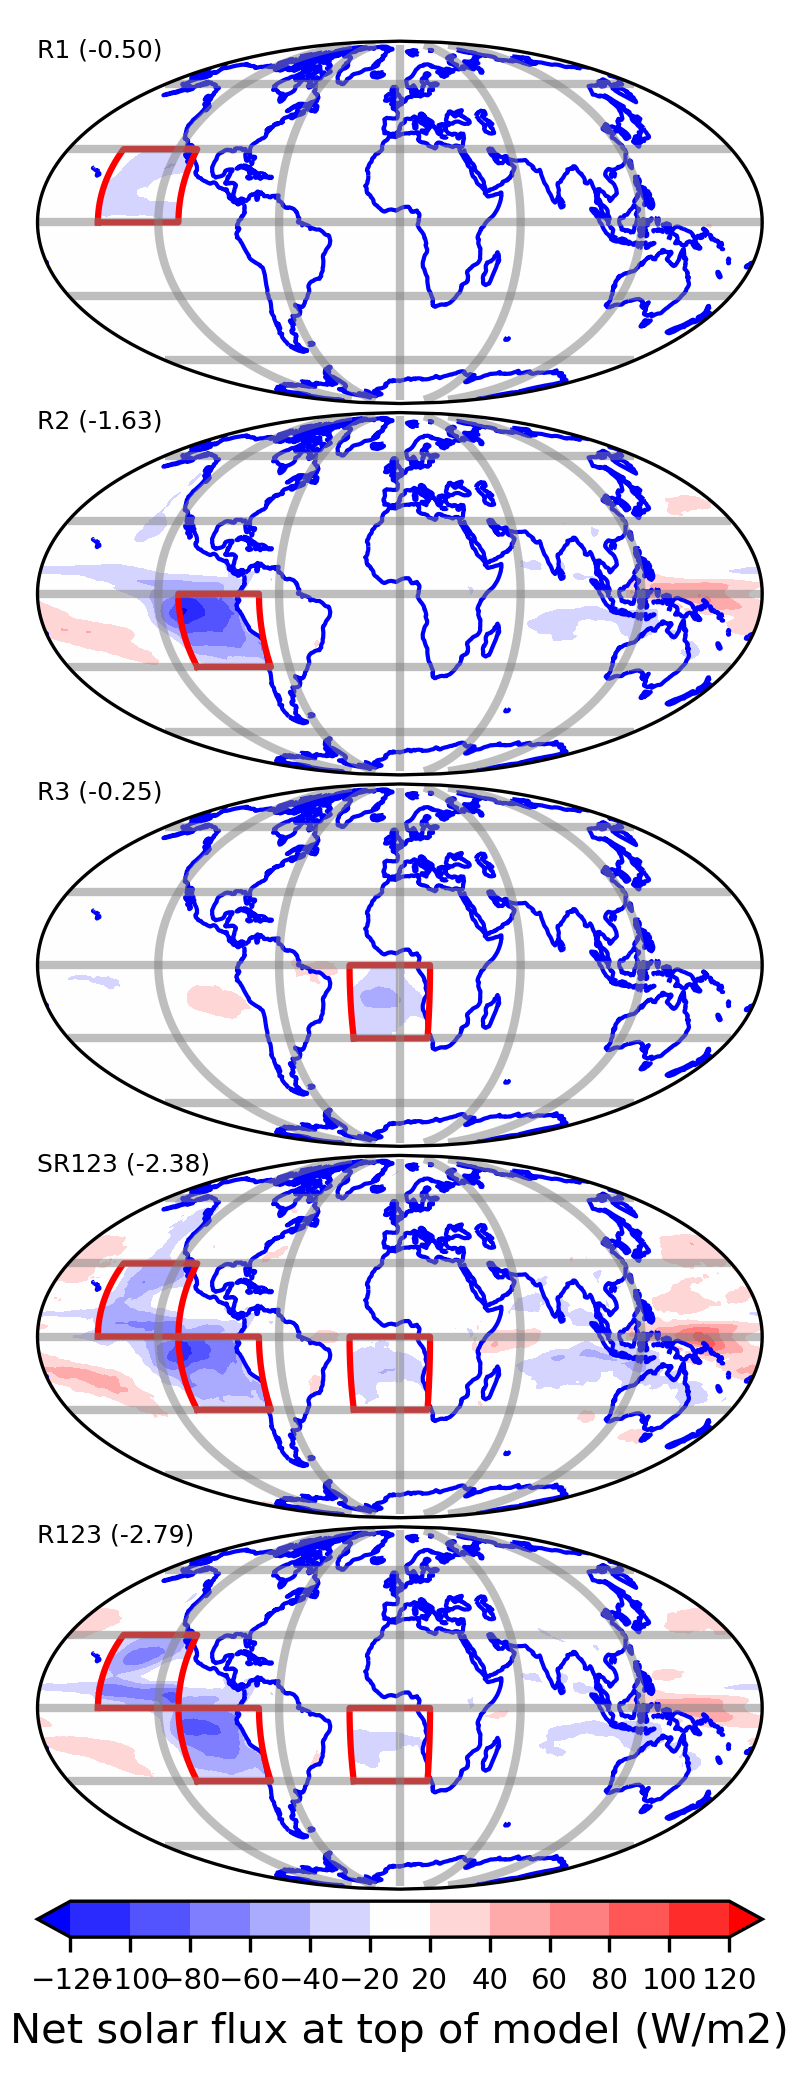

In [11]:
casename0 = "b.e21.BSSP245smbb.f09_g17.001"  # reference run
casename1 = "b.e21.BSSP245smbb_MCB600cm_R1.f09_g17.LE2-1011.001"
casename2 = "b.e21.BSSP245smbb_MCB600cm_R2.f09_g17.LE2-1011.001"
casename3 = "b.e21.BSSP245smbb_MCB600cm_R3.f09_g17.LE2-1011.001"
casename123 = "b.e21.BSSP245smbb_MCB600cm_R1R2R3.f09_g17.LE2-1011.001"
pref1='R1'
pref2='R2'
pref3='R3'
prefS='SR123'
pref123='R123'
prefmod='CESM_Coupled_MCB600'

Varname='FSNT'
#Varname='SWCF'
#Varname='TS'
#Varname='PRECT'


def bld_fname2(casename, Varname):
    fname = "/e3sm_prod/phil/timeseries/cesm2-mcb-reshaped/"+casename+"/"+casename+".cam.h0.2015-2064."+Varname+".nc"
    return fname

def bld_fname3(casename, Varname):
    fname = "/e3sm_prod/phil/timeseries/cesm2-mcb-reshaped/CESM2_SSP245/ens001/"+casename+".cam.h0."+Varname+".201501-206412.nc"
    return fname

ind0 = bld_fname3(casename0, Varname)
print('ind0',ind0)
ind1 = bld_fname2(casename1, Varname)
print('ind1',ind1)
ind2 = bld_fname2(casename2, Varname)
print('ind2',ind2)
ind3 = bld_fname2(casename3, Varname)
print('ind3',ind3)
ind123 = bld_fname2(casename123, Varname)
print('ind3',ind123)

DS0 = center_time(xr.open_mfdataset(ind0))
DS1 = center_time(xr.open_mfdataset(ind1))
DS2 = center_time(xr.open_mfdataset(ind2))
DS3 = center_time(xr.open_mfdataset(ind3))
DS123 = center_time(xr.open_mfdataset(ind123))

#print('DS0',DS0)
#print('DS1',DS1)
DS0, DS1 = reconcile_xr_coords(DS0, DS1)
DS0, DS2 = reconcile_xr_coords(DS0, DS2)
DS0, DS3 = reconcile_xr_coords(DS0, DS3)
DS0, DS123 = reconcile_xr_coords(DS0, DS123)

# grab part of the data
#DS0 = DS0.isel(time=slice(0,120))
yb = '2020-01-01'
ye = '2030-01-01'
DS0 = DS0.sel(time=slice(yb,ye))
DS1 = DS1.sel(time=slice(yb,ye))
DS2 = DS2.sel(time=slice(yb,ye))
DS3 = DS3.sel(time=slice(yb,ye))
DS123 = DS123.sel(time=slice(yb,ye))

#print(Var)
#VarAA = make_AA_tser(Var)
#print(VarAA)

long_name = None
if Varname == 'PRECT': long_name = 'Precip'
if Varname == 'TS': long_name = "Surface Temperature"
    
C0 = xr_getvar(Varname, DS0,long_name=long_name).mean(dim="time")
C1 = xr_getvar(Varname, DS1,long_name=long_name).mean(dim="time")
C2 = xr_getvar(Varname, DS2,long_name=long_name).mean(dim="time")
C3 = xr_getvar(Varname, DS3,long_name=long_name).mean(dim="time")
C123 = xr_getvar(Varname, DS123,long_name=long_name).mean(dim="time")

if 'area' in DS1:
    area = DS1['area']
elif 'area' in DS2:
    area = DS2['area']
else:
    print('calculating weights')
    lat = DS1['lat'].values
    lon = DS1['lon'].values
    aread = make_fvarea(lon,lat)
    area = xr.DataArray(aread, dims=['lat','lon'], coords={'lon':lon,'lat':lat})
    area.attrs['units']='steradians'
    #print('area',area)

wdims = area.dims
#print('wdims',wdims)
weights = area/(area.sum(dim=wdims))
#print('weights sum',weights.shape,weights.sum(dim=wdims).values)
    

#dlevs=None
#clevs=None

C0A = C0.weighted(weights).mean()
print("C0A",C0A.values)

# produce the synthetic estimate of the forcing, which is the sum of the forcings minus 2*control
CumS = (C1+C2+C3) - 2*C0
CumSA = CumS.weighted(weights).mean()
CSAD = CumSA - C0A
print("CSAD,C0A",CSAD.values,C0A.values)

C1A = C1.weighted(weights).mean()
C1AD = C1A - C0A
#print('C1A,V2A',C1A.values,V2A.values)
#print(C1AD)
sC1AD = ' (%5.2f)' % C1AD
dlevs = None

fig, axes = setfig()

D1 = C1-C0
D2 = C2-C0
D3 = C3-C0
DS = CumS - C0
D123 = C123-C0
SD123A= ' (%5.2f)' % D123.weighted(weights).mean().values
print('SD123A',SD123A)

print('min',D1.min().values)
drmin = np.min([D1.min(), D2.min(), D3.min(), DS.min(), D123.min()])
drmax = np.max([D1.min(), D2.max(), D3.max(), DS.max(), D123.max()])
print('drmin', drmin, drmax)
dlevs = findNiceContours(np.array([drmin,drmax]),nlevs = 15,rmClev=0.,sym=True)
dmap = diverge_map()

if True:
    xr_llhplot2(D1, ax=axes[0],clevs=dlevs,cmap=dmap,title=pref1+sC1AD, ylabels=False,cbar=None)
    pltllbox2([-150.,-110.],[0.,30.],ax=axes[0])
    #pltllbox2([-110.,-70.],[-30.,0.],ax=axes[0])
    #pltllbox2([-25.,15.],[-30.,0.],ax=axes[0])

C2A = C2.weighted(weights).mean()
C2AD = C2A - C0A
#print(C2AD)
sC2AD = ' (%5.2f)' % C2AD
if True:
    xr_llhplot2(D2, ax=axes[1],clevs=dlevs,cmap=dmap,title=pref2+sC2AD, ylabels=False,cbar=None)
    #pltllbox2([-150.,-110.],[0.,30.],ax=axes[1])
    pltllbox2([-110.,-70.],[-30.,0.],ax=axes[1])
    #pltllbox2([-25.,15.],[-30.,0.],ax=axes[1])

C3A = C3.weighted(weights).mean()
C3AD = C3A - C0A
#print(C3AD)
sC3AD = ' (%5.2f)' % C3AD
if True:
    xr_llhplot2(D3, ax=axes[2],clevs=dlevs,cmap=dmap,title=pref3+sC3AD, ylabels=False,cbar=None)
    #pltllbox2([-150.,-110.],[0.,30.],ax=axes[2])
    #pltllbox2([-110.,-70.],[-30.,0.],ax=axes[2])
    pltllbox2([-25.,15.],[-30.,0.],ax=axes[2])

sCSAD = ' (%5.2f)' % CSAD
xr_llhplot2(DS, ax=axes[3],clevs=dlevs,cmap=dmap,title=prefS+sCSAD, ylabels=False,cbar=None)
pltllbox2([-150.,-110.],[0.,30.],ax=axes[3])
pltllbox2([-110.,-70.],[-30.,0.],ax=axes[3])
pltllbox2([-25.,15.],[-30.,0.],ax=axes[3])

sCSAD = 'xx'#' (%5.2f)' % CSAD
xr_llhplot2(D123, ax=axes[4],clevs=dlevs,cmap=dmap,title=pref123+SD123A, ylabels=False)
pltllbox2([-150.,-110.],[0.,30.],ax=axes[4])
pltllbox2([-110.,-70.],[-30.,0.],ax=axes[4])
pltllbox2([-25.,15.],[-30.,0.],ax=axes[4])
plt.savefig(prefmod+'_'+Varname+'-D.pdf',format='pdf',dpi=300,transparent=True)#,facecolor='xkcd:mint green')
plt.show()

In [8]:
1./0.

ZeroDivisionError: float division by zero

In [ ]:
# plt.style.use('fivethirtyeight')


regtag = ""
weights = None

Varlist = np.array(['RESTOM','FLNT','FSNT','TS','TMQ','PRECT','AEROD_v','CLDLOW','CLDTOT','LWCF','SWCF','TGCLDIWP','TGCLDLWP',
                    'SHFLX','LHFLX','PBLH','PCONVT','PRECC','PRECS'])
Varlist = np.array(['FLNT','FSNT','TS','PRECC','PRECL','CLDLOW','CLDTOT','LWCF','SWCF','TGCLDIWP','TGCLDLWP',
                    'SHFLX','LHFLX','PBLH','PRECSC','PRECSL'])
#Varlist = np.array(['TS','TMQ','PRECT'])
#Varlist = np.array(['RESTOM','LWCF','SWCF','FLNT','FSNT'])
#Varlist = np.array(['AEROD_v'])
Varlist = np.array(['FSNT','FSNTC','FLNT','FLNTC'])
Varlist = np.array(['SWCF','TGCLDLWP','CLDLOW'])
#Varlist = np.array(['FSUTOA','FSNT','FSNTC'])
Varlist = np.array(['PRECC'])
Varlist = np.array(['CLDTOT','TGCLDLWP','FSNT','FSNTC','AODVIS'])
Varlist = np.array(['CLDTOT'])
Varlist = np.array(['TGCLDLWP'])
Varlist = np.array(['SWCF'])
Varlist = np.array(['FSNT'])
#Varlist = np.array(['SOLIN'])


for Varname in Varlist:
    print()
    print('-------------------------------'+Varname)    
    ind1 = fstring1 % (case_start1,Varname,case_end1)
    print('opening',ind1)
    DS1 = xr.open_mfdataset(ind1)
    #print('xxx',DS1.time)
    DS1 = center_time(DS1)
    # define a reference DataSet that we reconcile all datasets to
    DSR = DS1.copy()
    ind2 = fstring2 % (case_start2,Varname,case_end2)
    print('opening ind2',ind2)
    #DS2 = xr.open_mfdataset(ind2)
    DS2 = xr.open_mfdataset(ind2)
    DS2 = center_time(DS2)
    
    DSR, DS1 = reconcile_xr_coords(DSR, DS1)
    DSR, DS2 = reconcile_xr_coords(DSR, DS2)
    
    Var1 = xr_getvar(Varname,DS1)
    V1 = Var1.mean(dim='time',keep_attrs=True)
    Var2 = xr_getvar(Varname,DS2)
    V2 = Var2.mean(dim='time',keep_attrs=True)

    DV = V1-V2
    print('DV range', DV.min().values, DV.max().values)
    if 'area' in DS1:
        area = DS1['area']
    elif 'area' in DS2:
        area = DS2['area']
    else:
        print('calculating weights')
        lat = Var1['lat'].values
        lon = Var1['lon'].values
        aread = make_fvarea(lon,lat)
        area = xr.DataArray(aread, dims=['lat','lon'], coords={'lon':lon,'lat':lat})
        area.attrs['units']='steradians'
        #print('area',area)
        
    wdims = area.dims
    #print('wdims',wdims)
    weights = area/(area.sum(dim=wdims))
    #print('weights sum',weights.shape,weights.sum(dim=wdims).values)
    
    print(Varname, V1.attrs['long_name'],'Range V1 and V2 ',V1.min().values, V1.max().values, V2.min().values, V2.max().values)
    V1A = V1.weighted(weights).mean()
    sV1A = ' (%5.2f)' % V1A
    V2A = V2.weighted(weights).mean()
    sV2A = ' (%5.2f)' % V2A
    DVA = V1A-V2A
    sDVA = ' (%5.2f)' % DVA
    print('area avgs '+pref1+' %5.2f' % (V1A.values),' '+pref2+' %5.2f' % (V2A.values),' Delta %5.2f' % (DVA.values))

        
    print('field processing complete')
    SWCF_NCCLIMO_RIGHT = V1


In [ ]:
    if V1.min().values == V1.max().values:
        print('constant field skipping plot ')
    else:
        clev_rng = {'CDNUMC':np.array([0.,3.e11]),'FSNT':np.array([40.,360]),
                    'TGCLDLWP':np.array([0.,280.]),'PRECL':np.array([0.,10.]),
                    'PRECC':np.array([0.,16.]),'SWCF':np.array([-140.,0.]),
                    'CLDLOW':np.array([0.,90.]),'AODVIS':np.array([0,0.2]),
                    'XXX':np.array([-45.,45.]),
                   }
        dlev_rng = {'CDNUMC':np.array([0.,3.e11])/2.,'FSNT':np.array([-45.,45.]),
                   'TGCLDLWP':np.array([-50.,50.]),'PRECL':np.array([-1.,1.]),
                    'PRECC':np.array([-1.,1.]),'SWCF':np.array([-45.,45.]),
                    'CLDLOW':np.array([-10.,10.]),'AODVIS':np.array([-.9,.9]),
                    'CLDTOT':np.array([-10.,10.]),
                   }
        if Varname in clev_rng:
            clevs = findNiceContours(clev_rng[Varname],nlevs = 12)
        else:
            clevs = findNiceContours(np.array([V1.values,V2.values]),nlevs = 12)
        if Varname in dlev_rng:
            dlevs = findNiceContours(dlev_rng[Varname],nlevs = 15,rmClev=0.,sym=True)
        else:
            dlevs = findNiceContours(np.array([DV.min().values,DV.max().values]),nlevs = 15, rmClev=0.,sym=True)
        #dlevs = [-5.,-2.,-1.,-0.5,-0.2,-0.1,0.1,0.2,0.5,1.,2.,5.]
        #print('xxx',dlevs)
        dmap = diverge_map()

        fig, axes = setfig()
        # choose colorbar below bottom axis
        if not hasattr(axes, "__len__"):
            axz = axes # axis to plot
            axo = axes # axis to append colorbar
        else:
            axf = axes.flatten()
            axz = axf[0] # axis to plot
            axo = axf[-1] # axis to append colorbar

        #pl = xr_llhplot2(DV, ax=axz,clevs=dlevs,cmap=dmap,title=pref1+'-'+pref2+sDVA, ylabels=False,cbar=None)
        pl = xr_llhplot2(DV, ax=axz,clevs=dlevs,cmap=dmap,title=None, ylabels=False,cbar=None)
        #pl = xr_llhplot2(DV, ax=axz,clevs=dlevs,cmap=dmap,title=None, ylabels=False)
        pltllbox2([-150.,-110.],[0.,30.],ax=axz)
        pltllbox2([-110.,-70.],[-30.,0.],ax=axz)
        pltllbox2([-25.,15.],[-30.,0.],ax=axz)

        if True:
            ## Find the location of the main plot axes
            ## has to be done after some work is done in projection space (ax.setglobal() is enough)
            axo.set_global()
            posn = axo.get_position()
            # create an colorbar axis
            cax = fig.add_axes([0,0,0.1,0.1])
            cbartitle='xxx'
            ## Adjust the positioning and orientation of the colorbar
            cax.set_position([posn.x0, posn.y0-0.02, posn.width, 0.015])
            cb = plt.colorbar(pl,
                 orientation='horizontal',ticks=dlevs,cax=cax,
                 label='%s (%s)'%(cbartitle, DVA.units)
                 )
            cb.ax.tick_params(labelsize=8)
        plt.show()
        plt.savefig(pref1+'_'+Varname+'-D.pdf',format='pdf',dpi=300,transparent=True)#,facecolor='xkcd:mint green')


